# Quality Control Reports

Create a report quality checking an individual unit.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.utils.extract import get_range
from spiketools.utils.epoch import epoch_spikes_by_range, epoch_spikes_by_event
from spiketools.plts.utils import save_figure

In [3]:
import sys
sys.path.append('../code')
from plts import *

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/Claire_han/Documents/Data/JacobsLab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv001',
    'session' : 2
}

In [7]:
# Set which example unit to extract
uind = 0

## Load data

In [8]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)
nwbfiles

['THF_wv001_session_0.nwb',
 'THF_wv001_session_2.nwb',
 'THF_wv001_session_3.nwb',
 'THF_wv001_session_4.nwb',
 'THF_wv002_session_0.nwb',
 'THF_wv002_session_1.nwb',
 'THF_wv003_session_0.nwb',
 'THF_wv004_session_0.nwb',
 'THF_wv004_session_1.nwb',
 'THF_wv005_session_0.nwb',
 'THO_wv001_session_0.nwb',
 'THO_wv001_session_2.nwb',
 'THO_wv002_session_0.nwb',
 'THO_wv002_session_2.nwb',
 'THO_wv003_session_0.nwb',
 'THO_wv003_session_1.nwb',
 'THO_wv004_session_0.nwb',
 'THO_wv004_session_1.nwb',
 'THO_wv004_session_2.nwb',
 'THO_wv004_session_3.nwb',
 'THO_wv005_session_0.nwb']

In [9]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

In [10]:
# Get the trail information
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
openings = nwbfile.trials.chest_opening_time[:]

In [11]:
# Reset nav_stops per trial
nav_stops_trial = [nav_stops[ind] - nav_starts[ind] for ind in range(len(nav_stops))]

In [12]:
# Get the spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

## Example unit

In [13]:
# Epoch & reset spikes within each navigation period per trial
name = nwbfile.session_id + '_U' + str(uind).zfill(2)
spikes_trial = epoch_spikes_by_range(spikes, nav_starts, nav_stops, reset=True)

In [14]:
# Compute the firing rate per trial
nav_spikes = []
frs = np.zeros(len(spikes_trial))
for ind in range(len(spikes_trial)): 
    t_spikes = get_range(spikes, nav_starts[ind], nav_stops[ind])
    nav_spikes.append(t_spikes)
    nav_spikes_all = np.concatenate(nav_spikes).ravel()
    
    frs[ind] = compute_firing_rate(spikes_trial[ind])

In [15]:
# Add hlines for each block of trials
if (len(nav_starts) > 16) and (len(nav_starts) <= 24):
    hlines = [7.5, 15.5]
elif len(nav_starts) > 24:
    hlines = [7.5, 15.5, 23.5]

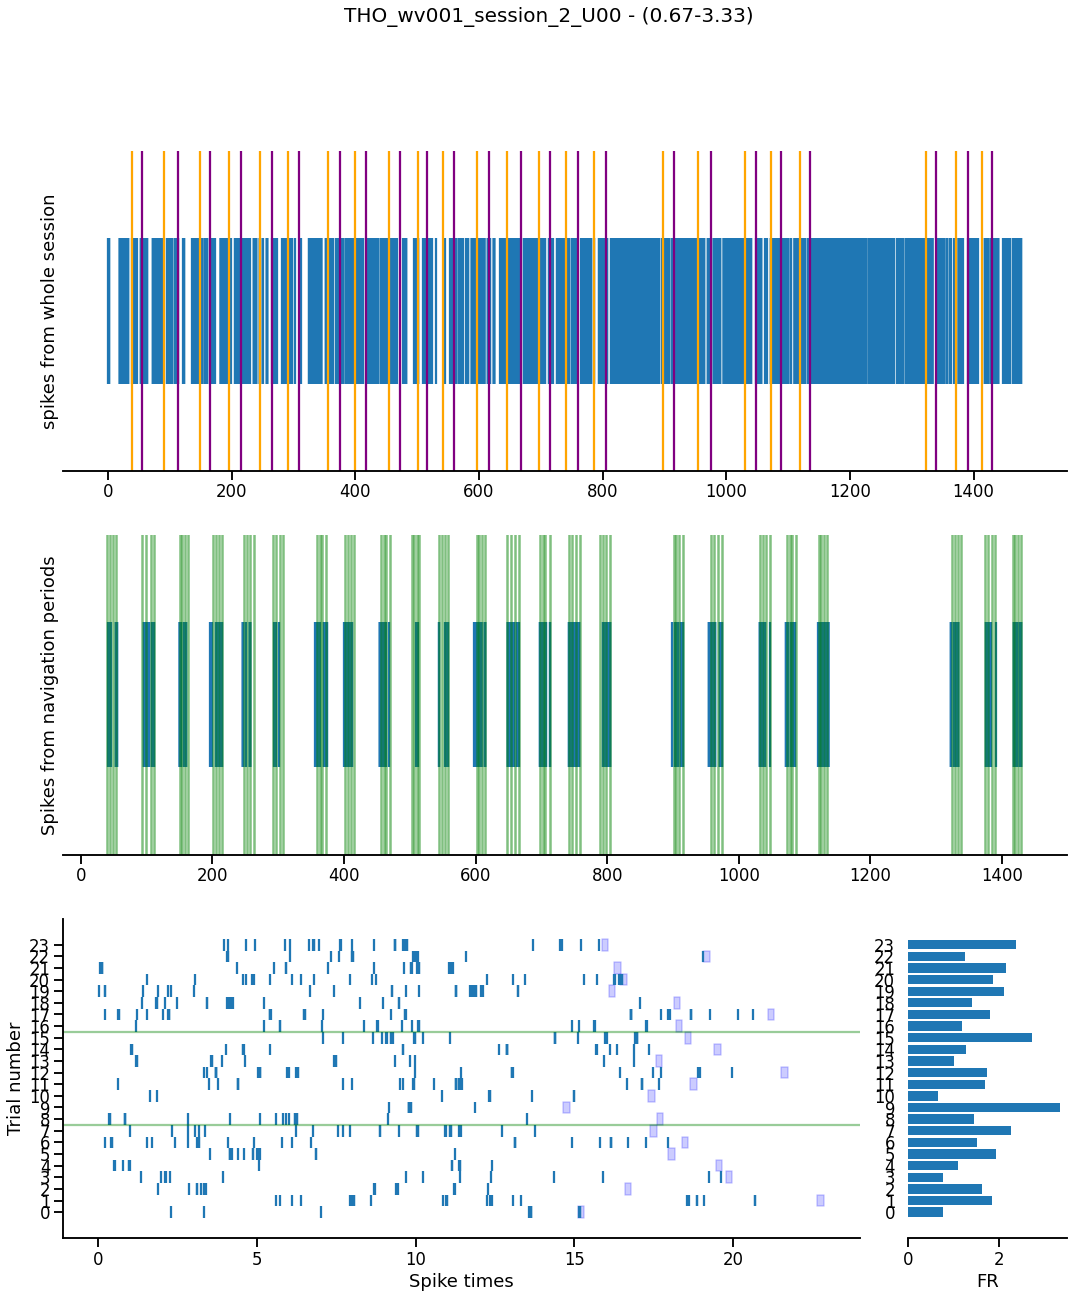

In [16]:
# Plot the unit report
plot_spikes_trial(spikes, spikes_trial, nav_stops_trial, nav_spikes_all, nav_starts, 
                      nav_stops, openings, name, frs, hlines)

## All units

In [ ]:
for nwbfile in nwbfiles:
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    
    # Check the number of units & keep indices
    n_units = len(nwbfile.units)
    keep_inds = np.where(nwbfile.units.keep[:])[0]
    
    # Drop sessions with 8 or fewer trials   
    n_trials = len(nwbfile.trials)
    if n_trials > 8: 
        nav_starts = nwbfile.trials.navigation_start[:]
        nav_stops = nwbfile.trials.navigation_stop[:]
        chest_openings = nwbfile.trials['chest_opening_time'][:]
        openings = nwbfile.trials.chest_opening_time[:]

        # Reset nav_stops per trial
        nav_stops_trial = [nav_stops[ind] - nav_starts[ind] for ind in range(len(nav_stops))]

        # Add hlines for each block of trials
        if (len(nav_starts) > 16) and (len(nav_starts) <= 24):
            hlines = [7.5, 15.5]
        elif len(nav_starts) > 24:
            hlines = [7.5, 15.5, 23.5]

        for index in keep_inds:
            name = nwbfile.session_id + '_U' + str(index).zfill(2)
            spikes = nwbfile.units.get_unit_spike_times(index)
            spikes_trial = epoch_spikes_by_range(spikes, nav_starts, nav_stops, reset=True)
            tc_spikes = epoch_spikes_by_range(spikes, nav_starts, nav_stops, reset=False)

            # Compute the overall firing rate and apply the 0.5 Hz threshold 
            fr_overall = compute_firing_rate(spikes)
            if fr_overall > 0.5:

                # Compute the firing rate per trial
                nav_spikes = []
                frs = np.zeros(len(spikes_trial))
                for ind in range(len(spikes_trial)): 
                    t_spikes = get_range(spikes, nav_starts[ind], nav_stops[ind])
                    nav_spikes.append(t_spikes)
                    nav_spikes_all = np.concatenate(nav_spikes).ravel()
                    if len(tc_spikes[ind]) != 0: 
                        frs[ind] = compute_firing_rate(tc_spikes[ind], start_time=nav_starts[ind], 
                                                        stop_time=nav_stops[ind])
                    else:
                        frs[ind] = 0
                        
                # Plot the unit report
                plot_spikes_trial(spikes, spikes_trial, nav_stops_trial, nav_spikes_all, nav_starts, 
                                  nav_stops, openings, name, frs, hlines)
                save_figure('unit_report_' + name + '.pdf', '../reports/threshold+trial', close=True)